In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchcps.kernel.rkhs import GaussianKernel
from torchcps.kernel.nn import (
    KernelConv,
    KernelMap,
    KernelGraphFilter,
    KernelPool,
    KernelNorm,
    RKHS,
)

In [3]:
# create a datset of 2D signals with noise
n_samples = 50_000
n_dimensions = 2
n_measurements = 20

with torch.no_grad():
    targets = 50 * torch.rand(n_samples, n_dimensions) - 25
    # convert to polar coordinates
    targets_range = torch.norm(targets, dim=-1)
    targets_bearing = torch.atan2(targets[..., 1], targets[..., 0])
    # add noise to make measurements
    measurements_range = (
        targets_range[..., None] + torch.randn(n_samples, n_measurements) * 1.0
    )
    measurements_bearing = (
        targets_bearing[..., None] + torch.randn(n_samples, n_measurements) * 0.5
    )
    # convert back to cartesian coordinates
    measurements = torch.stack(
        [
            measurements_range * torch.cos(measurements_bearing),
            measurements_range * torch.sin(measurements_bearing),
        ],
        dim=-1,
    )

In [4]:
# evaluate naive strategy of taking mean of measurements
input_mean = measurements.mean(dim=1)
(input_mean - targets).abs().mean()

tensor(1.8064)

In [13]:
n_channels = 1
max_kernels = 500
n_weights = 128
filter_kernels = 25
fixed_positions = True
pool_strategy = "random"
sigma = [2.0, 2.0, 2.0]
nonlinearity = nn.LeakyReLU()


def model_factory():
    n_layers = len(sigma)
    layers: list[nn.Module] = []
    for l in range(n_layers):
        first_layer = l == 0
        last_layer = l == n_layers - 1
        layers += KernelNorm[
            (
                n_channels if not first_layer else 1,
                n_weights if not first_layer else 1,
            ),
            KernelConv(
                filter_kernels=filter_kernels,
                in_channels=n_channels if not first_layer else 1,
                out_channels=n_channels if not last_layer else 1,
                n_dimensions=2,
                kernel_spread=sigma[l],
                fixed_positions=fixed_positions,
                n_weights=n_weights if not first_layer else 1,
            ),
            KernelMap(
                nn.Linear(
                    n_weights if not first_layer else 1,
                    n_weights,
                )
            ),
            KernelMap(nonlinearity) if not last_layer else KernelMap(nn.LeakyReLU()),
            KernelMap(
                nn.Linear(
                    n_weights,
                    n_weights if not last_layer else 1,
                )
            ),
            KernelMap(nonlinearity) if not last_layer else KernelMap(nn.LeakyReLU()),
            KernelPool(
                max_kernels,
                GaussianKernel(sigma[l]),
                nonlinearity,
                strategy=pool_strategy,
                alpha=0.1,
                fit=False,
            )
            if not last_layer
            else None,
        ]
    layers = [l for l in layers if l is not None]
    return nn.Sequential(*layers)

In [14]:
from torch.optim import AdamW
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(measurements.cuda(), targets.cuda())
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = model_factory().cuda()

# positions should not be regularized
parameters = list(model.named_parameters())
positions = [p for n, p in parameters if "_positions" in n]
other = [p for n, p in parameters if "_positions" not in n]
optimizer = AdamW(
    [dict(params=positions, lr=1e-4, weight_decay=0.0), dict(params=other)],
    lr=5e-3,
    weight_decay=0,
)

mse_values = []
for i in range(5):
    pbar = tqdm(dataloader, total=len(dataloader))
    for x, y in pbar:
        x = x[:, None, ...]
        y = y[:, None, None, :]
        x_weights = torch.ones(*x.shape[:-1], device="cuda")[..., None]
        y_weights = torch.ones(*y.shape[:-1], device="cuda")[..., None]
        z, z_weights = model(RKHS(x, x_weights))

        kernel = GaussianKernel(sigma[-1])
        mae_mode = kernel.squared_error(y, y_weights, z, z_weights).mean(0).sum()
        mse_values.append(mae_mode.item())
        pbar.set_postfix(loss=mae_mode.item())

        mae_mode.backward()
        optimizer.step()
        optimizer.zero_grad()

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

1.0227062940597533


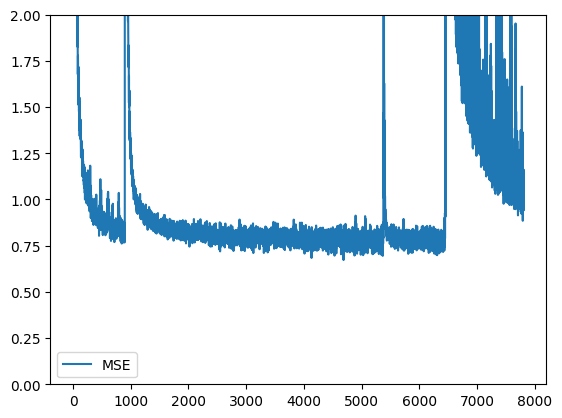

In [15]:
print(np.mean(mse_values[-10:]))

plt.figure()
plt.plot(mse_values, label="MSE")
plt.legend()
plt.ylim(0, 2)
plt.show()

In [16]:
def raster_rkhs(X: RKHS, sigma: float, width: float, resolution: int):
    XY = (
        torch.stack(
            torch.meshgrid(
                torch.linspace(-width / 2, width / 2, resolution),
                torch.linspace(-width / 2, width / 2, resolution),
            ),
            dim=-1,
        )
        .reshape(-1, 2)
        .to(X.positions.device)
    )
    kernel = GaussianKernel(sigma)
    values = kernel(XY, X.positions[0, 0]) @ X.weights
    XY = XY.reshape(resolution, resolution, 2).detach()
    values = values.reshape(resolution, resolution).detach()
    return values, XY

In [17]:
n_test = 100
indices = np.random.choice(n_samples, n_test, replace=False)

model.eval()
mae_mean = 0
mae_mode = 0
with torch.no_grad():
    for idx in tqdm(indices):
        x = measurements[None, idx, None, ...].cuda()
        y = targets[None, idx, None, None, :].cuda()
        x_weights = torch.ones(*x.shape[:-1], device=x.device)[..., None]
        y_weights = torch.ones(*y.shape[:-1], device=y.device)[..., None]
        Z: RKHS = model(RKHS(x, x_weights))

        # output argmax
        values, XY = raster_rkhs(Z, sigma[-1], 100, 1000)
        # expectation
        mean_xy = (XY * values[..., None]).sum((0, 1)) / values.sum()
        mae_mean += ((mean_xy - y.squeeze()).abs()).sum() / n_test
        # mode
        mode_xy = XY.reshape(-1, 2)[torch.argmax(values)]
        mae_mode += ((mode_xy - y.squeeze()).abs()).sum() / n_test
print(f"Mean Absolute Error (MEAN): {mae_mean.item():.2f}")
print(f"Mean Absolute Error (MODE): {mae_mode.item():.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean Absolute Error (MEAN): 15.10
Mean Absolute Error (MODE): 8.64


RuntimeError: shape '[128, 128]' is invalid for input of size 262144

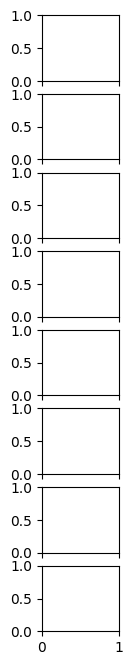

In [18]:
from torchcps.kernel.nn import RKHS


def raster_filter(X: RKHS, sigma: float, weight_idx, width: float, resolution: int):
    X_ = RKHS(X.positions, X.weights[..., weight_idx, None].contiguous())
    return raster_rkhs(X_, sigma, width, resolution)[0].detach().cpu()


# Plot the CNN Filter at the lth layer
l = 1
conv_layers = [layer for layer in model if isinstance(layer, KernelConv)]
positions = conv_layers[l].kernel_positions
weights = conv_layers[l].kernel_weights
n_weights = weights.shape[3]
fig, axs = plt.subplots(
    nrows=n_weights, figsize=(1, n_weights), sharex=True, sharey=True
)
for i in range(n_weights):
    rkhs = RKHS(positions, weights)
    width = sigma[l] * 10
    extent = np.array([-1, 1, -1, 1]) * width / 2
    if n_weights > 1:
        ax = axs[i]  # type: ignore
    else:
        ax = axs
    ax.imshow(
        raster_filter(rkhs, sigma[l], i, width=width, resolution=128),
        extent=extent,
        origin="lower",
    )
plt.show()

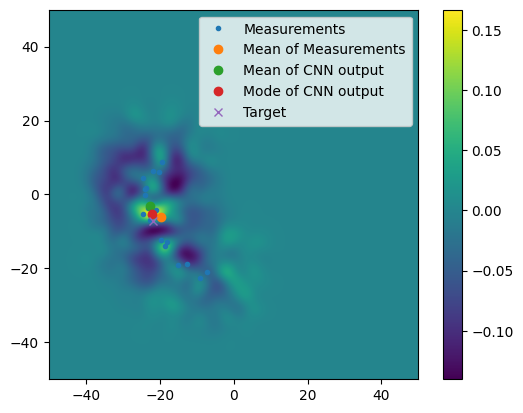

In [22]:
idx = np.random.randint(0, n_samples)
resolution = 1000

with torch.no_grad():
    x = measurements[None, idx, None, ...].cuda()
    y = targets[None, idx, None, None, :].cuda()
    x_weights = torch.ones(*x.shape[:-1], device=x.device)[..., None]
    y_weights = torch.ones(*y.shape[:-1], device=y.device)[..., None]

    model.eval()
    with torch.no_grad():
        z, z_weights = model(RKHS(x, x_weights))
    model.train()

    # squeeze all the tensors
    x = x.squeeze().cpu()
    y = y.squeeze().cpu()

    extent = [-50, 50, -50, 50]
    values, XY = raster_rkhs(RKHS(z, z_weights), sigma[-1], 100, 1000)
    # naive way to make predictions
    input_mean = x.mean(0)
    # expectation
    mean_xy = (XY * values[..., None]).sum((0, 1)) / values.sum()
    # mode
    mode_xy = XY.reshape(-1, 2)[torch.argmax(values)]

plt.figure()
plt.imshow(values.T.cpu().detach(), extent=extent, origin="lower")

plt.plot(*x.T, ".", label="Measurements")
plt.plot(*input_mean, "o", label="Mean of Measurements")
plt.plot(*mean_xy.detach().cpu(), "o", label="Mean of CNN output")
plt.plot(*mode_xy.detach().cpu(), "o", label="Mode of CNN output")
plt.plot(*y, "x", label="Target")

plt.xlim(extent[0], extent[1])
plt.ylim(extent[2], extent[3])

plt.legend()
plt.colorbar()
plt.show()